### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import StackingRegressor
import scipy.stats as stats
from xgboost import XGBRegressor
import lightgbm as lgb

### Load data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


### Data preparation

In [5]:
train = train.drop(['id'], axis=1)
id_ = test['id']

In [6]:
y = np.log1p(train['price'])

In [7]:
t_corr = train.select_dtypes(include=[float, int])
t_corr.corr()['price'].sort_values()

milage       -0.283067
model_year    0.231795
price         1.000000
Name: price, dtype: float64

### Visualization

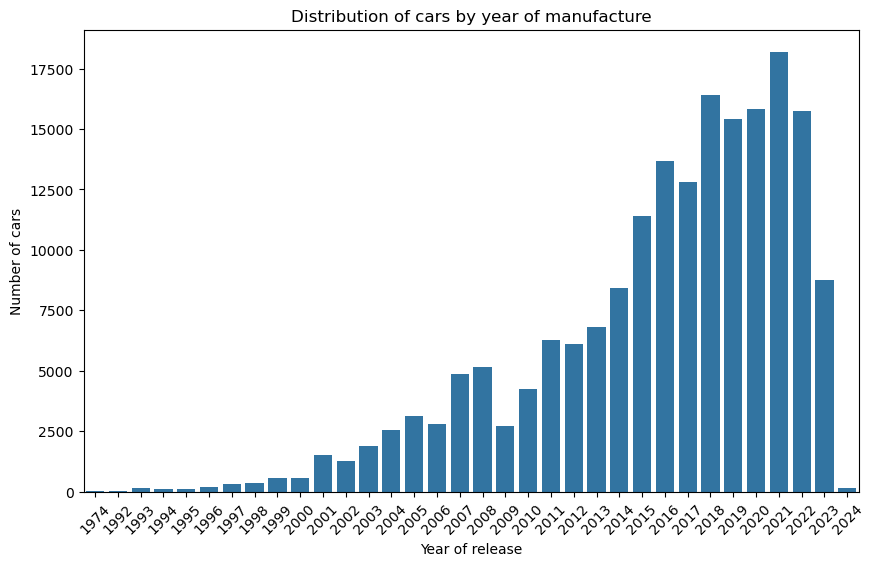

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='model_year')
plt.title('Distribution of cars by year of manufacture')
plt.xlabel('Year of release')
plt.ylabel('Number of cars')
plt.xticks(rotation=45)
plt.show()

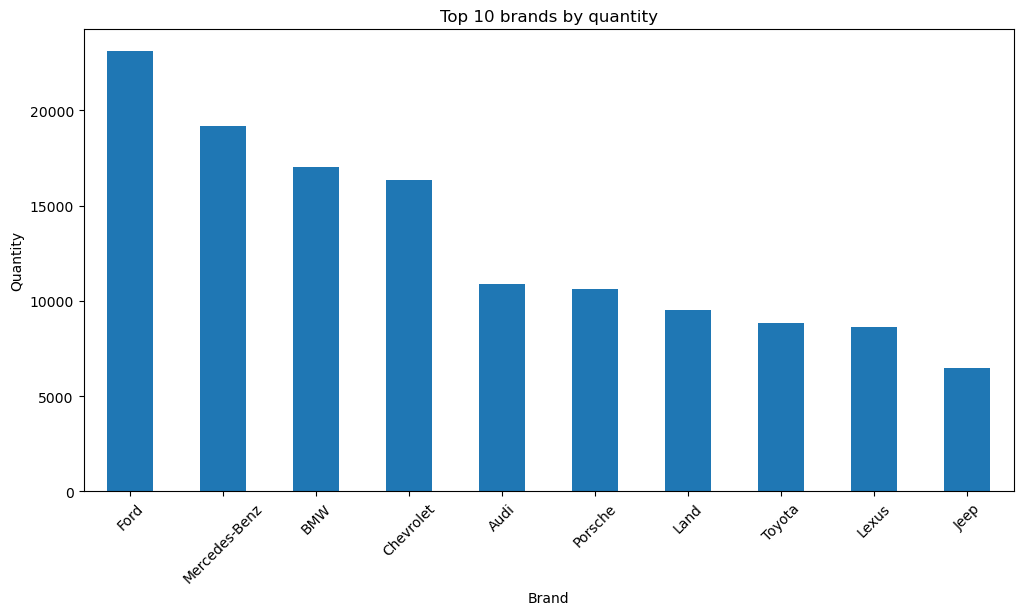

In [9]:
plt.figure(figsize=(12, 6))
train['brand'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 brands by quantity')
plt.xlabel('Brand')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

### Examining the data

In [10]:
t_band = train['brand'].unique()
print(t_band)

['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']


In [11]:
t_year = train['model_year'].unique()
print(t_year)

[2007 2002 2017 2021 2018 2016 2020 2015 2011 2013 2023 2019 2012 2014
 2008 2009 2022 2003 2005 2001 2006 2000 2010 2004 1997 1998 1999 1994
 1993 1996 1995 2024 1974 1992]


In [12]:
t_transmission = train['transmission'].unique()
print(t_transmission)

['A/T' 'Transmission w/Dual Shift Mode' '7-Speed A/T' '8-Speed A/T'
 '10-Speed Automatic' '1-Speed A/T' '6-Speed A/T' '10-Speed A/T'
 '9-Speed A/T' '8-Speed Automatic' '9-Speed Automatic' '5-Speed A/T'
 'Automatic' '7-Speed Automatic with Auto-Shift' 'CVT Transmission'
 '5-Speed M/T' 'M/T' '6-Speed M/T' '6-Speed Automatic' '4-Speed Automatic'
 '7-Speed M/T' '2-Speed A/T' '1-Speed Automatic' 'Automatic CVT'
 '4-Speed A/T' '6-Speed Manual' 'Transmission Overdrive Switch'
 '8-Speed Automatic with Auto-Shift' '7-Speed Manual' '7-Speed Automatic'
 '9-Speed Automatic with Auto-Shift' '6-Speed Automatic with Auto-Shift'
 '6-Speed Electronically Controlled Automatic with O' 'F' 'CVT-F'
 '8-Speed Manual' 'Manual' '–' '2' '6 Speed At/Mt' '5-Speed Automatic'
 '2-Speed Automatic' '8-SPEED A/T' '7-Speed' 'Variable'
 'Single-Speed Fixed Gear' '8-SPEED AT'
 '10-Speed Automatic with Overdrive' '7-Speed DCT Automatic'
 'SCHEDULED FOR OR IN PRODUCTION' '6-Speed' '6 Speed Mt']


In [13]:
t_accident = train['accident'].unique()
print(t_accident)

['None reported' 'At least 1 accident or damage reported' nan]


In [14]:
t_milage = train['milage'].value_counts()
print(t_milage)

milage
60000     1319
170000    1246
120000    1178
110000    1155
130000     970
          ... 
5111         1
29755        1
28761        1
170612       1
134603       1
Name: count, Length: 6651, dtype: int64


### Data preparation

In [15]:
train = train.drop(['price'], axis=1)
test = test.drop(['id'], axis=1)

In [16]:
df = pd.concat([train, test], axis=0)
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes


### Functions for searching and processing missing values

In [17]:
def percent_missing(df):
    total = 100 * df.isnull().sum() / len(df)
    total = total[total > 0].sort_values(ascending=False)
    return total

In [18]:
missing = percent_missing(df)
missing

clean_title    11.347992
fuel_type       2.694265
accident        1.299714
dtype: float64

In [19]:
def missing_data(df):
    df['fuel_type'].fillna(df['fuel_type'].mode()[0], inplace=True)
    df['clean_title'].fillna('Unknown', inplace=True)
    df['accident'].fillna('Unknown', inplace=True)
    return df

In [20]:
df = missing_data(df)

In [21]:
missing = perceg = percent_missing(df)
missing

Series([], dtype: float64)

### Main functions

In [22]:
current_year = 2024
def year(df):
    df['care_age'] = df['model_year'].apply(lambda x: current_year - x)
    return df

In [23]:
def brand_class(brand):
    premium = ['MINI', 'Lincoln', 'Genesis', 'Mercedes-Benz', 'Audi', 'BMW', 'Tesla', 'Land Rover', 'Volvo', 'Rivian', 'Porsche', 'McLaren', 'Lexus', 'Jaguar', 'Rolls-Royce', 'Maserati', 'Ferrari', 'Aston Martin', 'Lamborghini', 'Lotus', 'Bugatti', 'Polestar', 'Maybach']
    
    budget = ['Mitsubishi', 'Pontiac', 'Saturn', 'Scion', 'smart', 'Karma', 'Plymouth', 'Suzuki', 'FIAT', 'Saab', 'Mercury']
    
    if brand in premium:
        return 'Premium'
    elif brand in budget:
        return 'Budget'
    else:
        return 'Medium'

In [24]:
def color_category(color):
    premium_colors = ['Black', 'White', 'Silver', 'Gray', 'Blue']
    budget_colors = ['Yellow', 'Green', 'Orange', 'Pink']

    if color in premium_colors:
        return 'Premium'
    elif color in budget_colors:
        return 'Budget'
    else:
        return 'Medium'

In [25]:
def milage_group(milage):
    if milage < 50000:
        return 'Low'
    elif 50000 <= milage < 100000:
        return 'Medium'
    else:
        return 'High'

In [26]:
def year_group(year):
    if year < 2000:
        return 'Old'
    elif 2000 <= year < 2010:
        return '2000-2009'
    elif 2010 <= year < 2020:
        return '2010-2019'
    else:
        return 'New'

In [27]:
def transmission_group(trans):
    if 'A/T' in trans or 'Automatic' in trans:
        return 'Automatic'
    elif 'M/T' in trans or 'Manual' in trans:
        return 'Manual'
    elif 'CVT' in trans or 'DCT' in trans:
        return 'CVT/DCT'
    else:
        return 'Other'

In [28]:
def encode(df):
    ohe_features = ['brand_class', 'milage_group', 'year_group', 'transmission_group', 'color_category', 'accident', 'clean_title']
    fe_features = ['brand', 'model', 'fuel_type']
    num_features = ['model_year', 'milage', 'care_age']
    
    # One-Hot Encoding
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    ohe_encoded = ohe.fit_transform(df[ohe_features])
    ohe_columns = ohe.get_feature_names_out(ohe_features)
    
    # Frequency Encoding
    fe_encoded = pd.DataFrame()
    for feature in fe_features:
        fe_encoded[feature] = df[feature].map(df[feature].value_counts(normalize=True))
    
    scaler = StandardScaler()
    num_scaled = scaler.fit_transform(df[num_features])
    
    encoded_df = pd.concat([
        pd.DataFrame(ohe_encoded, columns=ohe_columns, index=df.index),
        fe_encoded,
        pd.DataFrame(num_scaled, columns=num_features, index=df.index)
    ], axis=1)
    
    return encoded_df

### Application of functions

In [29]:
df = year(df)
df['brand_class'] = df['brand'].apply(brand_class)
df['milage_group'] = df['milage'].apply(milage_group)
df['year_group'] = df['model_year'].apply(year_group)
df['transmission_group'] = df['transmission'].apply(transmission_group)
df['color_category'] = df['ext_col'].apply(color_category)
df = encode(df)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314223 entries, 0 to 125689
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   brand_class_Medium          314223 non-null  float64
 1   brand_class_Premium         314223 non-null  float64
 2   milage_group_Low            314223 non-null  float64
 3   milage_group_Medium         314223 non-null  float64
 4   year_group_2010-2019        314223 non-null  float64
 5   year_group_New              314223 non-null  float64
 6   year_group_Old              314223 non-null  float64
 7   transmission_group_CVT/DCT  314223 non-null  float64
 8   transmission_group_Manual   314223 non-null  float64
 9   transmission_group_Other    314223 non-null  float64
 10  color_category_Medium       314223 non-null  float64
 11  color_category_Premium      314223 non-null  float64
 12  accident_None reported      314223 non-null  float64
 13  accident_Unknown   

In [31]:
missing = percent_missing(df)
missing

Series([], dtype: float64)

### Separation before training

In [32]:
train = df[:len(train)]
test = df[len(train):]

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   brand_class_Medium          188533 non-null  float64
 1   brand_class_Premium         188533 non-null  float64
 2   milage_group_Low            188533 non-null  float64
 3   milage_group_Medium         188533 non-null  float64
 4   year_group_2010-2019        188533 non-null  float64
 5   year_group_New              188533 non-null  float64
 6   year_group_Old              188533 non-null  float64
 7   transmission_group_CVT/DCT  188533 non-null  float64
 8   transmission_group_Manual   188533 non-null  float64
 9   transmission_group_Other    188533 non-null  float64
 10  color_category_Medium       188533 non-null  float64
 11  color_category_Premium      188533 non-null  float64
 12  accident_None reported      188533 non-null  float64
 13  accident_Unknown   

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=1)

In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((131973, 21), (56560, 21), (131973,), (56560,))

### Model Parameters

In [36]:
params_lgb = {
    'subsample': 0.3,
    'reg_lambda': 9,
    'reg_alpha': 0.69,
    'num_leaves': 130,
    'n_estimators': 1000,
    'max_depth': 40,
    'learning_rate': 0.01,
    'colsample_bytree': 0.45,
    'early_stopping': 30,
    'verbose' : -1
}

In [37]:
lgb_model = lgb.LGBMRegressor(**params_lgb)

### Model Training

In [38]:
lgb_model.fit(X_train, y_train, 
              eval_set=[(X_test, y_test)], 
              eval_metric='rmse')

LGBMRegressor(colsample_bytree=0.45, early_stopping=30, learning_rate=0.01,
              max_depth=40, n_estimators=1000, num_leaves=130, reg_alpha=0.69,
              reg_lambda=9, subsample=0.3, verbose=-1)

In [39]:
y_pred = lgb_model.predict(X_test)

### Results

In [44]:
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
rmse = np.sqrt(mse)

print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')

MSE: 4516069113.7889
RMSE: 67201.7047


In [41]:
df_pred = np.expm1(lgb_model.predict(test))

### Saving

In [42]:
predictions = pd.DataFrame({
    'id': id_,
    'price': df_pred
})

In [43]:
predictions.to_csv('submission.csv', index=False)